### Association Rule Mining
Association Rule Mining adalah teknik data mining yang digunakan untuk menemukan hubungan menarik atau pola asosiasi antar item dalam dataset besar. Teknik ini sering digunakan dalam market basket analysis untuk mengidentifikasi produk yang sering dibeli bersama oleh pelanggan.

Dalam association rule mining, aturan asosiasi dinyatakan dalam bentuk:
"Jika A, maka B" atau bisa ditulis A → B.

A dan B adalah kumpulan item (produk yang dibeli),
Aturan ini mengindikasikan bahwa jika item A muncul dalam transaksi, maka kemungkinan besar item B juga akan muncul.

Beberapa metrik penting dalam association rule mining:
Support: Mengukur seberapa sering itemset tersebut muncul dalam dataset.
Confidence: Mengukur seberapa sering aturan A → B benar, yaitu seberapa besar kemungkinan item B muncul ketika A muncul.
Lift: Mengukur tingkat peningkatan probabilitas kemunculan B ketika A sudah muncul, dibandingkan dengan jika B muncul secara independen.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

EDA

In [3]:
# baca data csv
data = pd.read_csv('penjualan barang.csv')
data

,Unnamed: 0,tanggal,nama.pembeli,nama.barang,kuantum,nominal
0,1,2020-01-02,TOKO HERUNIAWATI,BERAS,1000.0,9840000.0
1,2,2020-01-02,TOKO HERUNIAWATI,DAGING,120.0,8400000.0
2,3,2020-01-02,TOKO APRILIA SUKRISNI,BERAS,6000.0,62910000.0
3,4,2020-01-02,TOKO APRILIA SUKRISNI,MIGOR,408.0,4855200.0
4,5,2020-01-02,TOKO APRILIA SUKRISNI,TEPUNG,140.0,1162000.0
...,...,...,...,...,...,...
1284,1285,2021-04-08,TOKO MAJU TERUS,DAGING,60.0,4389600.0
1285,1286,2021-04-08,TOKO KINORA,BERAS,250.0,2718750.0
1286,1287,2021-04-08,TOKO KINORA,TEPUNG,120.0,1065120.0
1287,1288,2021-04-09,TOKO BERKAH DUA PUTRA,GULA,100.0,1200000.0


In [ ]:
# gambaran umum data csv
# baris dan kolom, nama kolom dan tipe data, jumlah non-null entries, memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1289 non-null   int64  
 1   tanggal       1289 non-null   object 
 2   nama.pembeli  1289 non-null   object 
 3   nama.barang   1289 non-null   object 
 4   kuantum       1289 non-null   float64
 5   nominal       1289 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 60.6+ KB


In [ ]:
# ringkasan statistik kolom numerik di dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1289.0,6.450000e+02,3.722466e+02,1.0,323.0,645.0,967.0,1.289000e+03
kuantum,1289.0,1.735064e+03,6.300788e+03,2.0,140.0,600.0,1800.0,2.000000e+05
nominal,1289.0,1.929970e+07,6.489967e+07,46000.0,2964000.0,7650000.0,18900000.0,2.047000e+09


In [ ]:
# ngecek jumlah unique values pada setiap kolom
data.nunique()

Unnamed: 0      1289
tanggal          185
nama.pembeli     171
nama.barang        5
kuantum          206
nominal          573
dtype: int64

In [ ]:
# ngecek unique value dalam kolom
# if unique value < 10 : print nama kolom (i) + nama unique value
for i in data.columns:
    if (data[i].nunique() < 10):
        print ("Feature:\t", i, "\n", data[i].unique())

Feature:	 nama.barang 
 ['BERAS' 'DAGING' 'MIGOR' 'TEPUNG' 'GULA']


In [ ]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
['tanggal', 'nama.pembeli', 'nama.barang']
Numerical Variables:
['Unnamed: 0', 'kuantum', 'nominal']


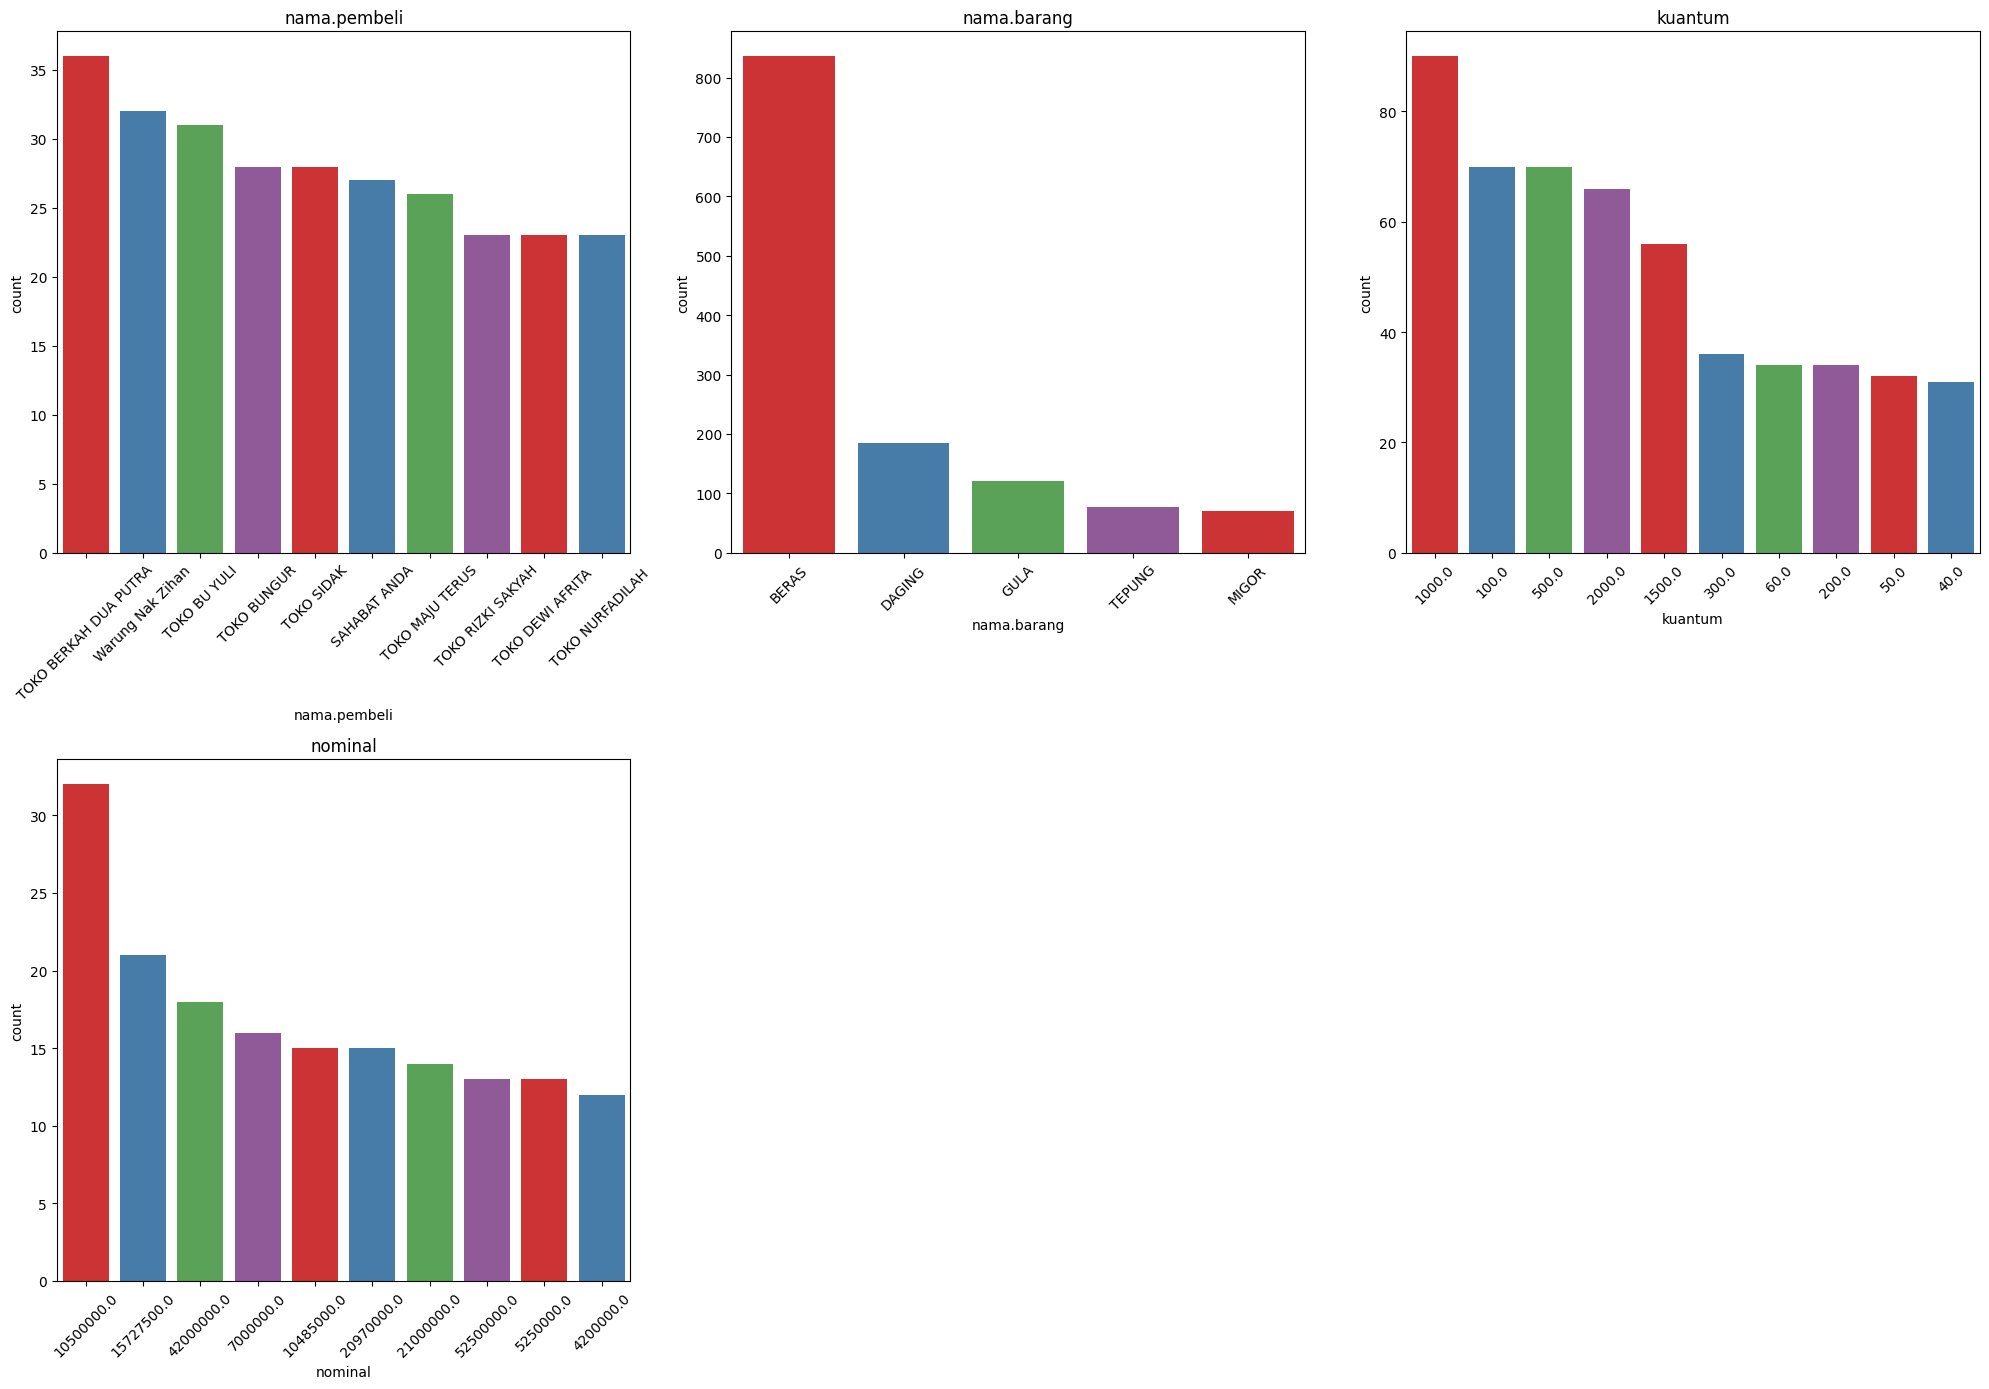

In [ ]:
# bertujuan untuk melihat faktor faktor yang memengaruhi pembelian dan barang yang paling sering dibeli
cat_cols = [
'nama.pembeli',
'nama.barang',
'kuantum',
'nominal'
]  

color_palette = sns.color_palette("Set1", len(cat_cols))

n_cols = 3
n_rows = (len(cat_cols) // n_cols) + 1  # menghitung jumlah baris untuk subplot

plt.figure(figsize=(20, n_rows * 7))

for i, column in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)

    # mengambil item pada kolom yang ditentukan sebanyak 10 item
    top_10_items = data[column].value_counts().nlargest(10).index
    
    # memastikan kolom berupa string
    # mengubah numerik menjadi string
    data[column] = data[column].astype(str)
    
    filtered_df = data[data[column].isin(top_10_items)]
    
    # countplot
    sns.countplot(data=filtered_df, x=column, palette=color_palette, order=top_10_items)
    
    plt.title(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Preprocessing

In [ ]:
# ngecek jumlah missing value pada setiap kolom
data.isnull().sum()

Unnamed: 0      0
tanggal         0
nama.pembeli    0
nama.barang     0
kuantum         0
nominal         0
dtype: int64

<Axes: >

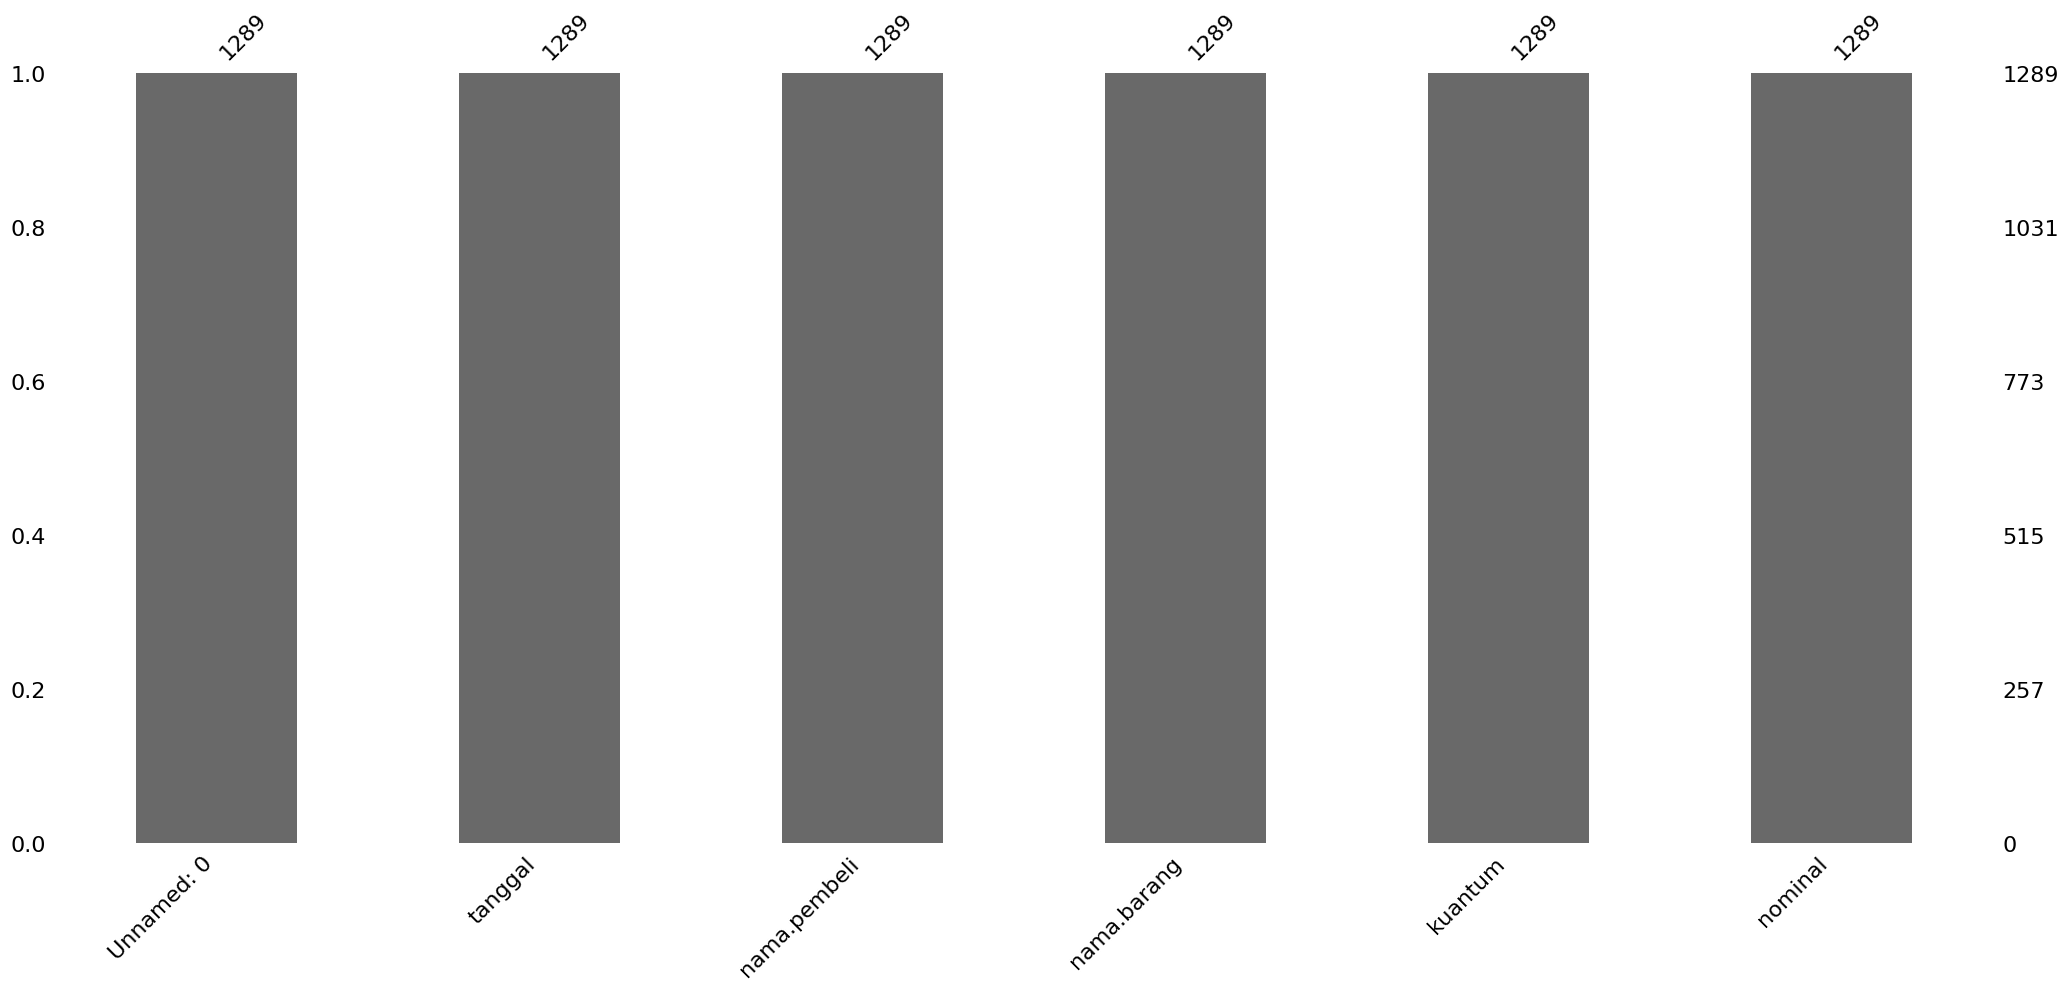

In [ ]:
msno.bar(data)

In [ ]:
# memisahkan kolom numerik dan kategorikal
numerical_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# isi missing values dengan rata-rata untuk kolom numerik
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())

# isi missing values dengan nilai modus untuk kolom kategorikal
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

Association Rule Mining

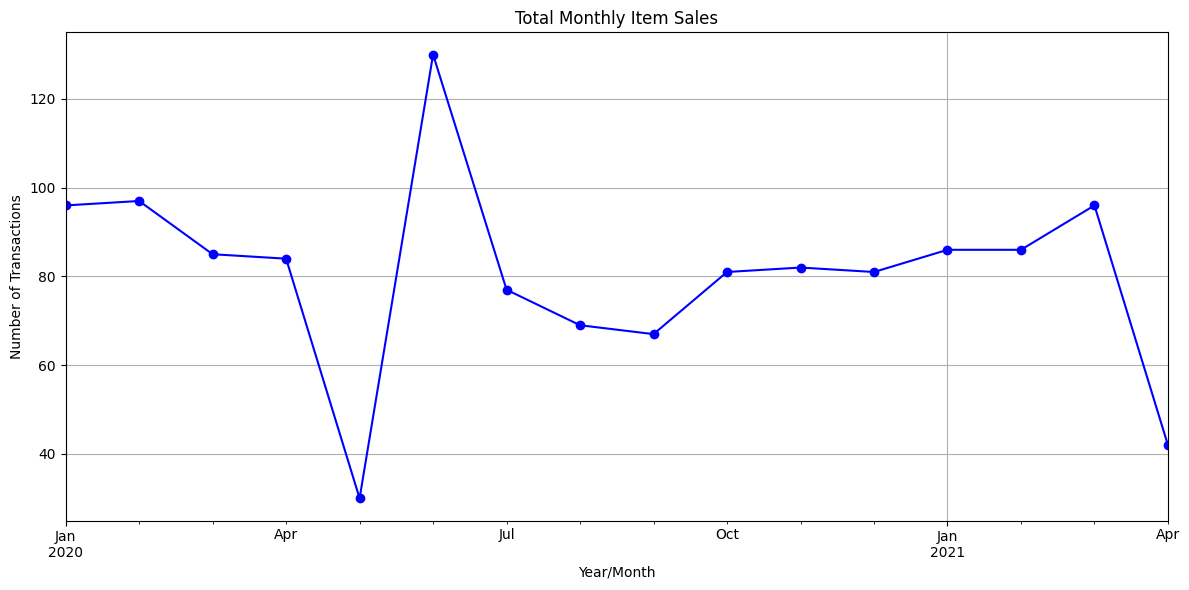

In [ ]:
data = pd.read_csv('penjualan barang.csv')

# Memastikan kolom 'tanggal' dalam format datetime
data['tanggal'] = pd.to_datetime(data['tanggal'], errors='coerce')

# Kolom 'year_month' dari kolom 'tanggal'
data['year_month'] = data['tanggal'].dt.to_period('M')

# Hitung total penjualan bulanan
monthly_sales = data.groupby('year_month').size()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.title('Total Monthly Item Sales')
plt.xlabel('Year/Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

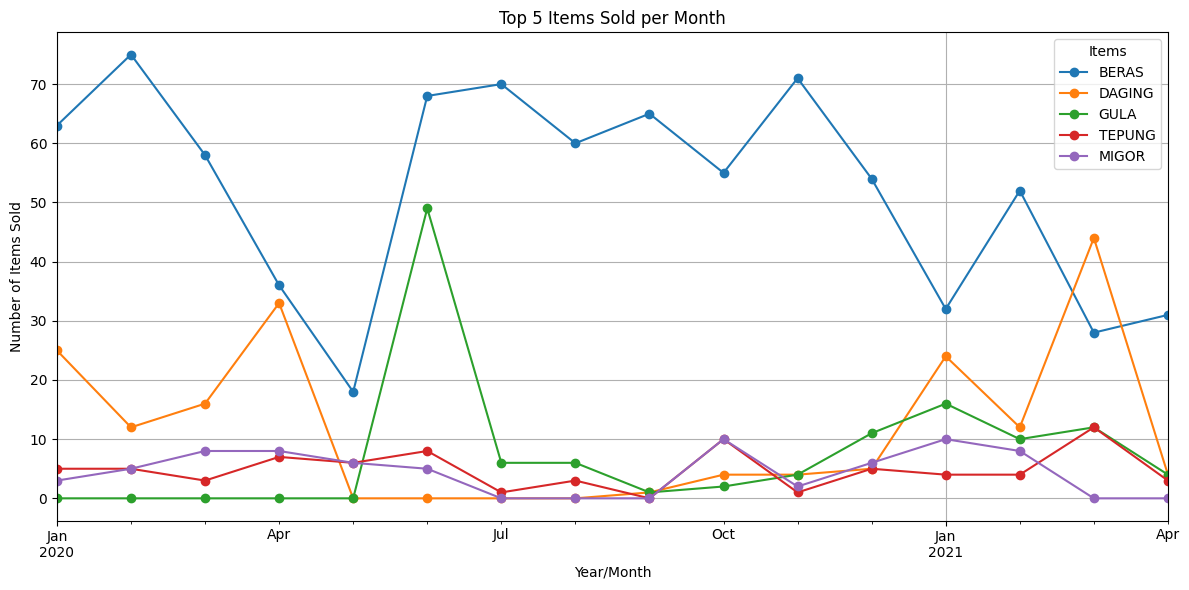

In [8]:
# Top 5 Items Sold per Month
monthly_items = data.groupby(['year_month', 'nama.barang']).size().unstack(fill_value=0)

top_items = monthly_items.sum().nlargest(5).index
monthly_top_items = monthly_items[top_items]

monthly_top_items.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Top 5 Items Sold per Month')
plt.xlabel('Year/Month')
plt.ylabel('Number of Items Sold')
plt.legend(title='Items')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

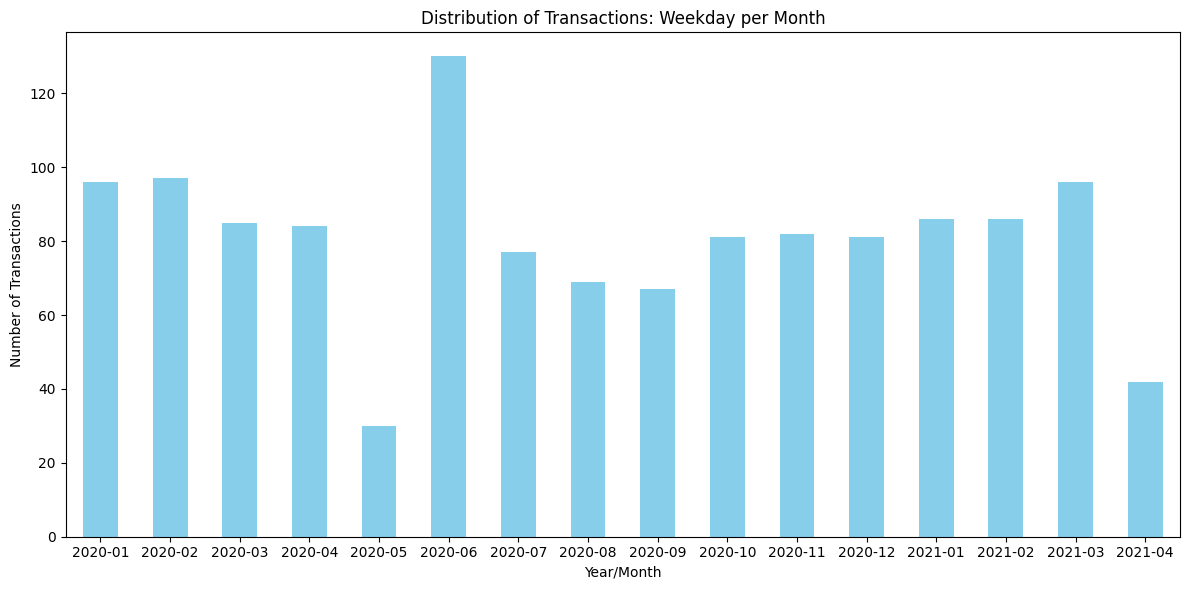

In [11]:
# Pastikan kolom 'tanggal' dalam format datetime
data['tanggal'] = pd.to_datetime(data['tanggal'])

# Hanya menjual pada hari biasa, Sabtu-Minggu libur
data['weekday'] = data['tanggal'].dt.dayofweek < 5  

# Filter untuk hanya menyertakan transaksi pada hari kerja
weekday_data = data[data['weekday'] == True]

# Distribusi Transaksi Hari Kerja per Bulan
monthly_distribution = weekday_data.groupby(['year_month']).size()

monthly_distribution.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Distribution of Transactions: Weekday per Month')
plt.xlabel('Year/Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Menggunakan 'nama.pembeli' sebagai ID transaksi dan 'nama.barang' sebagai item
data = data[['nama.pembeli', 'nama.barang']]

# Konversi ke One-Hot Encoding
# Pivot table untuk setiap barang yang dibeli oleh setiap pembeli
basket = data.pivot_table(index='nama.pembeli', columns='nama.barang', aggfunc=lambda x: 1, fill_value=0)

# Apriori
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Rules dari Frequent Itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Hasil Rules
print("Frequent Itemsets:")
print(frequent_itemsets)
print("\nAssociation Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Frequent Itemsets:
     support                              itemsets
0   0.912281                               (BERAS)
1   0.397661                              (DAGING)
2   0.286550                                (GULA)
3   0.192982                               (MIGOR)
4   0.187135                              (TEPUNG)
5   0.374269                       (DAGING, BERAS)
6   0.216374                         (GULA, BERAS)
7   0.175439                        (MIGOR, BERAS)
8   0.157895                       (TEPUNG, BERAS)
9   0.210526                        (DAGING, GULA)
10  0.140351                       (DAGING, MIGOR)
11  0.128655                      (DAGING, TEPUNG)
12  0.128655                         (GULA, MIGOR)
13  0.116959                        (GULA, TEPUNG)
14  0.169591                       (TEPUNG, MIGOR)
15  0.192982                 (DAGING, BERAS, GULA)
16  0.134503                (DAGING, MIGOR, BERAS)
17  0.116959               (DAGING, TEPUNG, BERAS)
18  0.122807

1. Pilih Kolom Penting
data = data[['nama.pembeli', 'nama.barang']]
Hanya diperlukan dua kolom: nama.pembeli sebagai ID transaksi dan nama.barang sebagai item yang dibeli. Kolom lainnya seperti tanggal, kuantum, dan nominal tidak dibutuhkan untuk association rule mining.

2. Konversi ke One-Hot Encoding
basket = data.pivot_table(index='nama.pembeli', columns='nama.barang', aggfunc=lambda x: 1, fill_value=0)
Pada tahap ini, data transaksi dikonversi ke dalam bentuk one-hot encoding.

Fungsi pivot_table membuat tabel di mana setiap baris adalah nama.pembeli dan setiap kolom adalah nama.barang.
Setiap sel memiliki nilai 1 jika pembeli membeli barang tertentu, dan 0 jika tidak.
Output:

nama.pembeli	BERAS	DAGING	MIGOR	TEPUNG
TOKO HERUNIAWATI	1	1	0	0
TOKO APRILIA	1	0	1	1

3. Algoritma Apriori
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
Pada tahap ini, frequent itemsets atau kombinasi item yang sering muncul dicari berdasarkan nilai min_support.

min_support=0.01 artinya kita hanya mempertimbangkan kombinasi item yang muncul setidaknya 1% dari total transaksi.
use_colnames=True akan membuat outputnya lebih mudah dibaca dengan menyertakan nama kolom item.
Output:

support	itemsets
0.1	{BERAS}
0.05	{BERAS, DAGING}

4. Rules dari Frequent Itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
Pada langkah ini, kita menghasilkan aturan asosiasi berdasarkan frequent itemsets yang telah ditemukan.

metric="confidence" menentukan bahwa kita hanya mempertimbangkan aturan dengan confidence tinggi.
min_threshold=0.5 artinya aturan harus memiliki confidence minimal 50%.
Confidence adalah probabilitas item muncul bersamaan dalam transaksi.

Aturan:

antecedents	consequents	support	confidence	lift
{BERAS}	{DAGING}	0.05	0.8	1.5
Artinya, 80% dari transaksi yang mencakup BERAS juga mencakup DAGING. Lift sebesar 1.5 menunjukkan bahwa kemungkinan BERAS dan DAGING muncul bersama 1.5 kali lebih besar dibandingkan munculnya DAGING secara terpisah.

5. Hasil
print("Frequent Itemsets:")
print(frequent_itemsets)
print("\nAssociation Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Tahap terakhir adalah menampilkan hasil frequent itemsets dan association rules yang telah ditemukan, termasuk informasi penting seperti support, confidence, dan lift untuk setiap aturan.

Kesimpulan
Dari aturan yang dihasilkan, dapat dilihat pola pembelian item mana yang sering muncul bersama dalam dataset. Hal ini bisa berguna untuk rekomendasi produk, penataan produk di toko, atau strategi pemasaran.